<div style="background-color: green; padding: 5px;">

# Part 1 - Downloading/extracting data from GC

In [ ]:
'''
from google.cloud import storage
client = storage.client.Client()
bucket_name = 'dev-zembo-data-dump'
bucket = client.get_bucket(bucket_name)
blob_name = 'battery-data-Apr-24.zip'
blob = bucket.blob(blob_name)
content = blob.download_as_text()
# No 'storage.buckets.get' permission - Try another method
'''

In [ ]:
# Import required modules
from zipfile import ZipFile # for working with zipped files
import requests # for access online data
import os # for working with directories, saving/accessing in local machine
import csv # for working with csv datasets
import pandas as pd # for dataframes
from pandas.errors import ParserError, EmptyDataError # for catching errors while trying to read csv files
import warnings
warnings.filterwarnings('ignore') # for cleaner code

In [ ]:
response = requests.get(bucket_url) # accessing the data online
with open(bucket_name + '.xml', 'wb') as file: # this downloads a list of names of all the available files
    file.write(response.content)

In [ ]:
# Separate zipped file names (where the csv files are stored) from text files to download them separately
filelist = pd.read_xml('dev-zembo-data-dump.xml')
filelist = filelist[filelist['Key'].isna()==False]
zip_files = filelist[filelist['Key'].str.contains('.zip')]['Key'].tolist()
txt_files = filelist[filelist['Key'].str.contains('.txt')]['Key'].tolist()

In [ ]:
# Iterate through the zip file names and download them into the current directory
for file in zip_files:
    print(f'Accessing {file}')
    resp = requests.get(bucket_url + file)
    print(f'Downloading {file}')
    with open(file, 'wb') as file:
        file.write(resp.content)
print('\nCSV DOWNLOAD COMPLETE')

In [ ]:
# Iterate through the text file names and download them into the current directory
for file in txt_files:
    print(f'Accessing {file}')
    resp = requests.get(bucket_url + file)
    print(f'Downloading {file}')
    with open(file, 'wb') as file:
        file.write(resp.content)
print('\nTXT DOWNLOAD COMPLETE')

In [ ]:
# creating new directories to save the extracted zip files
if os.path.isdir('extracted'):
    pass
else:
    os.mkdir('extracted')

if os.path.isdir('csv-files'):
    pass
else:
    os.mkdir('csv-files')

In [ ]:
# Now, extracting the zip files
extracted_path = f'{os.getcwd()}\\extracted'
for file in zip_files: # iterate through each zipped file
    print(f'Extracting {file}')
    ZipFile(f'{os.getcwd()}\\{file}', 'r').extractall(path=extracted_path) # extract each file into the directory created for this purpose
print('\nFIRST EXTRACTION COMPLETE')

In [ ]:
# The zipped files above contained other zipped files in them. Therefore, we perform another extraction to get the folders containing csv files
for dr in os.listdir(extracted_path)[:-1]:
    print(f'Working on {dr} ...')
    os.mkdir(f'{os.getcwd()}\\csv-files\\{dr}')
    for zip in os.listdir(f'{extracted_path}\\{dr}')[1:]:
        ZipFile(f'{extracted_path}\\{dr}\\{zip}', 'r').extractall(path=f'{os.getcwd()}\\csv-files\\{dr}')
print('\nFINAL EXTRACTION COMPLETE!')

In [ ]:
# Combining all csv fils into one master dataset

monthly_data = {} # initialize a dictionary to store monthly data

for folder in folders: # iterate through eacg month's folder
    folder_path = os.path.join(base_path, folder) # get the folder path
    files = os.listdir(folder_path) # list files in that folder
    month_name = folder[3:6].lower() # get the month name from the folder name
    print(f'\nImporting data for {folder}') # start import
    data_list = [] # initialize list to store chuckes of data read from the same file
    
    for file in files: # for each file in the folder
        file_path = os.path.join(folder_path, file) # get the file name
        
        try: # try reading the full file normaly
            df = pd.read_csv(file_path)
            data_list.append(df)

        except ParserError: # catch parser error - where some rows are longer than the length of top row headers.
            print(f'ParserError in file {file}. Attempting to fix...')
            fixed_data = []
            with open(file_path, 'r') as file: # splits the file into sections and imports them seprately
                reader = csv.reader(file)
                first_values = [row[0] if row else 'blank' for row in reader] # picks first value of each row
                break_rows = [index for index, value in enumerate(first_values) if value == '_time'] # picks the rows where the first valu is '_time'

            for i in range(len(break_rows) - 1): # in case of parser error, import file in sections and combine the at the end
                fixed_df = pd.read_csv(
                    file_path,
                    skiprows=break_rows[i],
                    nrows=break_rows[i + 1] - break_rows[i] - 1,
                    skip_blank_lines=False
                )
                fixed_data.append(fixed_df)

            if fixed_data:
                data_list.append(pd.concat(fixed_data, ignore_index=True))

        except EmptyDataError: # skip empty files
            print(f"File {file} is empty. Skipping...")

        except Exception as e:
            print(f"Unexpected error in file {file}: {e}")
    
    print(f'Attempting to combine data for {folder}')
    monthly_data[month_name] = pd.concat(data_list, ignore_index=True)
    print(f'\nFinished importing data from {folder}')

In [ ]:
# combine all datasets in the disctionary to a single file
final_data = pd.concat(monthly_data.values(), ignore_index=True)
final_data.head()

In [ ]:
# final_data.to_csv('raw-data.csv', index=False)

<div style="background-color: green; padding: 5px;">

# Part 2 - Data Pre-Processing

In [ ]:
# Import required libraries
import pandas as pd # for working with dataframes
import numpy as np # for mathematical computations
import warnings # for clean code and output
warnings.filterwarnings('ignore')

In [ ]:
# Read the raw data
raw_data = final_data.copy()
# raw_data = pd.read_csv('raw-data.csv')
raw_data.shape

#### 1. Drop repeated column labels

In [ ]:
# Drop repeated column labels
raw_data.drop(
    index=raw_data[[i == '_time' for i in raw_data['_time']]].index,
    inplace=True)

raw_data.shape

#### 2. Handling inconsistent data types
- Checking for multiple data types in the columns...

In [ ]:
# This shows all the data types contained in each column
for col in raw_data.columns:
    types = set([type(i) for i in raw_data[col]])
    print(f'{col} | {types}')

- All have two data types: `float` and `string`
- We expected `time` column to be of dtype `str`. Let's investigate the `float` cases

In [ ]:
# checking if the float cases are missing values
assert sum([type(i)==float for i in raw_data['_time']]) == raw_data['_time'].isna().sum()

- We see that the `float` cases are all missing values.
- Upon further investigation shown below, we find that these rows are all missing an important feature - `time`.
- Let's drop them - this is only 1% of the entire dataset, therefore we'll still have a significant sample.

In [ ]:
dropped_counter = raw_data['_time'].isna().sum() # Keep this to track number of dropped rows
print(f'Dropped {raw_data['_time'].isna().sum()} rows: {raw_data['_time'].isna().sum() / raw_data.shape[0]:.2%}')
clean_data = raw_data[raw_data['_time'].isna()==False] # drop entries that are missing the time feature
clean_data.head()

- Now we inspect column `devId`
- We expect `devId` to be of dtype`str`. Let's investigate the `float` cases.

In [ ]:
# Confirming that the float cases are also missing values
assert clean_data[[type(i)==float for i in clean_data['devId']]].shape[0] == clean_data['devId'].isna().sum()

- Confirmed. They are all missing values.
- We drop them as well, as devId is the identifier column and we can't make sense out of the data without it.

In [ ]:
dropped_counter = dropped_counter + clean_data['devId'].isna().sum() # update dropped rows counter
print(f'Dropped {clean_data['devId'].isna().sum()} more rows: {clean_data['devId'].isna().sum()/raw_data.shape[0]:.2%}')
clean_data = clean_data[clean_data['devId'].isna()==False]

- Now, we inspect the third column further
- Expected data type is `float`

In [ ]:
clean_data[[type(i)==str for i in clean_data['BMS_PCB_board_surface_temperature']]]

- Observation : Rows containing values `3500, 3650, etc.` in the first column are cell voltages misplaced in the first column.
- The voltages belong to the previous column.
- Let's fix this

In [ ]:
# Start by getting these rows where voltages are misplaced in the fisrt column
# Call this a temporary dataset - to be reintegrated to the main one later
temp = clean_data[[len(i)==4 for i in clean_data['_time']]][clean_data.columns[:33]]
temp.head()

In [ ]:
# Drop the rows from the main dataset before re-indexing the temp dataset (avoids duplicate rows)
clean_data.drop(index=temp.index, inplace=True)

In [ ]:
# Reset index to pick the previous row
temp.set_index(temp.index-1, inplace=True)
temp.head()

In [ ]:
# Rename columns of temp dataset
col_rename = dict([[temp.columns[i], clean_data.columns[24:][i]] for i in range(33)])
temp.rename(columns=col_rename, inplace=True)
temp.head()

In [ ]:
# Now replace these in the main dataset
clean_data.update(temp)

- Another observation: In column `_time`, items starting with 'BGU' should be `devId` and are misplaced in column 1.
- Push them one column to the right (on the previous row)

In [ ]:
# Get the affected rows
temp = clean_data[[i[:3]=='BGU' for i in clean_data['_time']]]
temp.head()

In [ ]:
# Drop them before reindexing
clean_data = clean_data.drop(index=temp.index)

# Reset index of temp subset
temp.set_index(temp.index-1, inplace=True)
temp.head()

In [ ]:
# Rename columns of temp dataset
temp.drop(columns=temp.columns[-1], inplace=True)
col_rename =dict([[clean_data.columns[i], clean_data.columns[i+1]] for i in range(clean_data.shape[1]-1)])
temp.rename(columns=col_rename, inplace=True)

# Now replace these in the main dataset
clean_data.update(temp)

In [ ]:
clean_data[[len(i)<20 for i in clean_data['_time']]].shape # checking which ones have unexpected values as time

- For the remaining rows with data type `str` in third column, we can't identify which columns they belong to
- They are also way out of range. We can drop them at this point.

In [ ]:
dropped_counter = dropped_counter + clean_data[[len(i)<20 for i in clean_data['_time']]].shape[0]

clean_data.drop(
    index=clean_data[[len(i)<20 for i in clean_data['_time']]].index,
    inplace=True)

clean_data.shape

- We can confirm that the rest are convertible to float/integer
- Note: since we've fixed the column misalignment, this has also fixed the datatype differences in all other columns

In [ ]:
# Convert the rest to float
temp = clean_data[clean_data.columns[2:]].map(lambda x : float(x))
clean_data.update(temp)

# To confirm the datatype issues are all sorted out.
for col in clean_data.columns:
    types = set([type(i) for i in clean_data[col]])
    print(f'{col} | {types}')

#### 3. Drop rows with incomplete devId

In [ ]:
drop_index = clean_data[clean_data['devId'].str.len()!=7].index
dropped_counter = dropped_counter + drop_index.shape[0]
print(f'Dropping {drop_index.shape[0]} entries with incomplete devIdA')
clean_data.drop(index=drop_index, inplace=True)

#### 4. Check for duplicates

In [ ]:
# Drop duplicates
print(f'before:{clean_data.shape}')
dropped_counter = dropped_counter + clean_data.duplicated().sum()
print(f'There are {clean_data.duplicated().sum()} duplicates')
clean_data.drop_duplicates(inplace=True)
print(f'after:{clean_data.shape}')

In [ ]:
print(f'We only ended up dropping approx. {dropped_counter/raw_data.shape[0]:.2%} of the raw data')

In [ ]:
# clean_data.to_csv('clean-data.csv', index=False)

<div style="background-color: green; padding: 5px;">

# Part 3 - Data Aggregation

In [ ]:
# Import required libraries
import pandas as pd # for working with dataframes
import numpy as np # for mathematical computations
import warnings # for clean code and output
warnings.filterwarnings('ignore')

In [ ]:
final_data = clean_data.copy()
final_data.shape

In [ ]:
# get date from the time column
final_data['_date'] = pd.to_datetime(final_data['_time'].apply(lambda x : x[:10]))
final_data.drop(columns=['_time'], inplace=True)
final_data.head()

In [ ]:
# aggregate all cell voltage columns to get total cell voltage
cell_voltage_cols = final_data.columns[[col[:12]=='cell_voltage' for col in final_data.columns]]
final_data['total_cell_voltage'] = final_data[cell_voltage_cols].sum(axis=1)
final_data.drop(columns=cell_voltage_cols, inplace=True)
final_data.head()

In [ ]:
# get month from date column - for aggregation by month
final_data['_month'] = final_data['_date'].apply(lambda x: x.month)

In [ ]:
# the following columns have an issue with some entrie, fix it before aggregating.
final_data['BMS_PCB_board_surface_temperature'] = final_data['BMS_PCB_board_surface_temperature'].apply(lambda x : np.nan if x=='-' or (type(x)==str and x[0]=='{') else float(x))
final_data['Mileage'] = final_data['Mileage'].apply(lambda x : np.nan if x=='-' or (type(x)==str and x[0]=='{') else float(x))
final_data['Nominal_Capacity'] = final_data['Nominal_Capacity'].apply(lambda x : np.nan if x=='-' or (type(x)==str and x[0]=='{') else float(x))
final_data['Total_current'] = final_data['Total_current'].apply(lambda x : np.nan if x=='-' or (type(x)==str and x[0]=='{') else float(x))
final_data['Total_discharged_capacity'] = final_data['Total_discharged_capacity'].apply(lambda x : np.nan if x=='-' or (type(x)==str and x[0]=='{') else float(x))

In [ ]:
# A dictionary defining how to aggregate each column.
agg = {'BMS_PCB_board_surface_temperature' : 'mean',
'Battery_control' : lambda x: x.mode(),
'Battery_status' : lambda x: x.mode(),
'Cell_series_numbe_23_series' : lambda x: x.mode(),
'Internal_temperature_of_battery':'mean',
'Location_type' : lambda x: x.mode(),
'Mileage' : 'mean',
'Number_of_cycles' : 'mean',
'SOC' : 'mean',
'Speed_information' : 'mean',
'Surface_temperature_in_the_middle_of_cells' : 'mean',
'Total_charged_capacity' : 'mean',
'Total_current' : 'mean',
'Total_discharged_capacity' : 'mean',
'Total_voltage' : 'mean',
'alarmDesc' : lambda x: x.mode(),
'alarmFlag' : lambda x: x.mode(),
'times_100_of_battery_capacity' : 'mean',
'Maximum_Charge_Current' : 'mean',
'Nominal_Capacity' : 'mean',
'Total_charge_protect_voltage' : 'mean',
'total_cell_voltage' : 'mean'}

In [ ]:
# aggregating data monthly
grouped_data = final_data.groupby(['devId', '_month']).agg(agg).reset_index()
grouped_data = grouped_data.map(lambda x: np.nan if type(x)==np.ndarray else x)
grouped_data.head()

In [ ]:
# grouped_data.to_csv('grouped-data-bymonth.csv', index=False)

<div style="background-color: green; padding: 5px;">
    
# Part 4 - Battery clustering

- Group baterries into 5 distinct clusters based on battery features.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [2]:
km_data = pd.read_csv('files/grouped-data-bymonth.csv')
km_data.head()

,devId,_month,BMS_PCB_board_surface_temperature,Battery_control,Battery_status,Cell_series_numbe_23_series,Internal_temperature_of_battery,Location_type,Mileage,Number_of_cycles,...,Total_current,Total_discharged_capacity,Total_voltage,alarmDesc,alarmFlag,times_100_of_battery_capacity,Maximum_Charge_Current,Nominal_Capacity,Total_charge_protect_voltage,total_cell_voltage
0,BGU9001,8,27.310345,4.0,0.0,24.0,24.482759,5.0,4957.000000,88.000000,...,0.000000,2574.000000,7995.620690,0.0,0.0,2262.066667,40.00000,29.000000,8328.000000,2.204787e+03
1,BGU9001,9,33.223356,0.0,0.0,24.0,18.182772,1.0,4408.957220,4332.812933,...,667.369829,3029.557267,6985.655360,0.0,0.0,2032.953336,76.37356,65.426787,8214.132265,4.409521e+09
2,BGU9002,8,27.827586,4.0,2.0,24.0,25.206897,5.0,4421.000000,82.000000,...,0.000000,2385.000000,7851.655172,0.0,0.0,727.076923,40.00000,29.000000,8328.000000,1.741913e+03
3,BGU9002,9,32.594091,0.0,0.0,24.0,18.045939,1.0,3976.965473,4401.784499,...,680.447967,2927.316081,6997.518440,0.0,0.0,2085.513307,72.85449,62.058187,8217.235082,4.695004e+09
4,BGU9003,8,26.486486,4.0,0.0,24.0,24.000000,5.0,7279.000000,117.000000,...,0.000000,3394.000000,7704.567568,11.0,0.0,194.733333,40.00000,29.000000,8328.000000,1.968236e+03


In [3]:
# A dictionary defining how to aggregate each column.
battery_features = ['Battery_control',
                    'Battery_status',
                    'Cell_series_numbe_23_series',
                    'Location_type',
                    'Total_charged_capacity',
                    'alarmDesc',
                    'alarmFlag',
                    'times_100_of_battery_capacity',
                    'Maximum_Charge_Current',
                    'Total_charge_protect_voltage']

In [4]:
km_data = km_data.groupby('devId').agg('mean')[battery_features]

In [5]:
km = KMeans(n_clusters=5, max_iter=5000, verbose=1, random_state=0)
km_fit = km.fit(km_data)
km_data['cluster'] = km_fit.predict(km_data)

Initialization complete
Iteration 0, inertia 113751963.80914187.
Iteration 1, inertia 76325513.4206402.
Iteration 2, inertia 75062303.8207411.
Iteration 3, inertia 74873523.14763485.
Converged at iteration 3: strict convergence.


In [6]:
km_data.head()

,Battery_control,Battery_status,Cell_series_numbe_23_series,Location_type,Total_charged_capacity,alarmDesc,alarmFlag,times_100_of_battery_capacity,Maximum_Charge_Current,Total_charge_protect_voltage,cluster
devId,,,,,,,,,,,
BGU9001,2.0,0.0,24.0,3.0,2790.162696,0.0,0.0,2147.510001,58.186780,8271.066132,0
BGU9002,2.0,1.0,24.0,3.0,2659.672152,0.0,0.0,1406.295115,56.427245,8272.617541,4
BGU9003,2.0,0.0,24.0,3.0,3477.258219,5.5,0.0,903.056322,61.525019,8273.533589,4
BGU9004,2.0,0.0,24.0,3.0,4056.106145,0.0,0.0,1967.292336,68.534701,8271.747821,2
BGU9005,4.0,2.0,24.0,5.0,1971.561947,0.0,0.0,575.777546,40.000000,8324.603132,4


<div style="background-color: green; padding: 5px;">
    
# Part 5 - Swap data analysis

## Import required libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # for cleaner code

## Import raw data

In [8]:
# Import raw swap data
raw_swap_in_data = pd.read_csv('files/swap_in_data.txt', sep='\t')
raw_swap_out_data = pd.read_csv('files/swap_out_data.txt', sep='\t')

In [9]:
# take a look at the data
raw_swap_in_data.head()

,swap_in_date,battery_id,swap_in_SOC
0,2024-12-11 10:49:57,BGU10093,0.0
1,2024-12-11 10:49:44,BGU5005,0.0
2,2024-12-11 10:49:38,BGR1070,20.0
3,2024-12-11 10:47:33,BGR1107,22.0
4,2024-12-11 10:46:24,BGR1222,10.0


In [10]:
raw_swap_out_data.head()

,swap_out_date,battery_id,swap_out_SOC
0,2024-12-11 10:51:46,BGR1032,95.0
1,2024-12-11 10:49:57,BGU9486,100.0
2,2024-12-11 10:49:44,BGU5171,100.0
3,2024-12-11 10:49:38,BGU5084,100.0
4,2024-12-11 10:47:33,BGU5226,94.0


## Data pre-processing

- Restructuring data to be able to align swap out and swap in times

In [11]:
# introducing swap_type columns
swap_in_data = raw_swap_in_data.copy()
swap_out_data = raw_swap_out_data.copy()
swap_in_data['swap_type'] = np.repeat('in', swap_in_data.shape[0])
swap_out_data['swap_type'] = np.repeat('out', swap_out_data.shape[0])

In [12]:
# rename some columns for easier merge
swap_in_data = swap_in_data.rename(columns={'swap_in_date' : 'swap_date', 'swap_in_SOC' : 'swap_SOC'})
swap_out_data = swap_out_data.rename(columns={'swap_out_date' : 'swap_date', 'swap_out_SOC' : 'swap_SOC'})

In [13]:
# combining swap out and wap in data
temp_swap_data = pd.concat([swap_in_data, swap_out_data])
temp_swap_data = temp_swap_data.sort_values(by=['battery_id', 'swap_date'])
temp_swap_data = temp_swap_data.reset_index().drop(columns='index')
temp_swap_data.head()

,swap_date,battery_id,swap_SOC,swap_type
0,2024-01-02 08:55:16,BGR1001,100.0,out
1,2024-01-02 11:10:20,BGR1001,25.0,in
2,2024-01-02 13:53:30,BGR1001,100.0,out
3,2024-01-02 20:56:44,BGR1001,24.0,in
4,2024-01-03 10:24:03,BGR1001,100.0,out


In [14]:
# Finding the corresponding swap_out time for each swap_in

swap_in_index = temp_swap_data[temp_swap_data['swap_type'] == 'in'].index

swap_out_dates = []

for index in swap_in_index:
    try:
        assert (
            temp_swap_data.loc[index, 'battery_id'] == temp_swap_data.loc[index-1, 'battery_id'] and
            temp_swap_data.loc[index-1, 'swap_type'] == 'out'
        )
        
        swap_out_dates.append(temp_swap_data.loc[index-1, 'swap_date'])

    except AssertionError as e:
        print(f'AssertionError raised: {e}')
        swap_out_dates.append(np.nan)

    except Exception as e:
        print(f'Exception error found: {e}')
        swap_out_dates.append(np.nan)

AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError r

In [15]:
# Finding the corresponding swap_out SOC for each swap_in

swap_out_SOCs = []

for index in swap_in_index:
    try:
        assert (
            temp_swap_data.loc[index, 'battery_id'] == temp_swap_data.loc[index-1, 'battery_id'] and
            temp_swap_data.loc[index-1, 'swap_type'] == 'out'
        )
        
        swap_out_SOCs.append(temp_swap_data.loc[index-1, 'swap_SOC'])

    except AssertionError as e:
        print(f'AssertionError raised: {e}')
        swap_out_SOCs.append(np.nan)

    except Exception as e:
        print(f'Exception error found: {e}')
        swap_out_SOCs.append(np.nan)

AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError raised: 
AssertionError r

In [16]:
# confirming the shape of the result from above is as expected
assert len(swap_out_dates) == temp_swap_data[temp_swap_data['swap_type']=='in'].shape[0]
assert len(swap_out_SOCs) == temp_swap_data[temp_swap_data['swap_type']=='in'].shape[0]

In [17]:
# final swap data
swap_data = temp_swap_data[temp_swap_data['swap_type']=='in'] # dropping unwanted rows
swap_data['swap_out_date'] = swap_out_dates # introducing swap out dates
swap_data['swap_out_SOC'] = swap_out_SOCs # introducing swap out SOCs
swap_data = swap_data.rename(columns = {'swap_date' : 'swap_in_date', 'swap_SOC' : 'swap_in_SOC'}) # renaming columns for clarity
swap_data.drop(columns='swap_type', inplace=True) 
swap_data.head()

,swap_in_date,battery_id,swap_in_SOC,swap_out_date,swap_out_SOC
1,2024-01-02 11:10:20,BGR1001,25.0,2024-01-02 08:55:16,100.0
3,2024-01-02 20:56:44,BGR1001,24.0,2024-01-02 13:53:30,100.0
5,2024-01-03 15:19:49,BGR1001,18.0,2024-01-03 10:24:03,100.0
7,2024-01-03 23:40:09,BGR1001,39.0,2024-01-03 21:56:09,100.0
9,2024-01-04 15:20:46,BGR1001,35.0,2024-01-04 09:12:12,100.0


In [18]:
swap_data.to_csv('swap_data.csv', index=False) # saving progress

## Analysis

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

## Create functions for use in the analysis

In [20]:
# Create function for later use in time conversions

def tdelta_to_hours(tdelta):
    if pd.isna(tdelta):
        return np.nan
    
    else:
        return tdelta.value / 3600000000000 # convert nanosecond to hour

In [21]:
# A function to check trend of a series - returns the slope of a fitted linear regression

def get_trend(series):
    if sum(series.isna()) == len(series):
        return np.nan
    
    else:
        months = list(range(1, len(series.dropna()) + 1))
        reg = linregress(months, series.dropna())
        return reg.slope

1. Find the "usage_time" between swaps

In [22]:
# bring in combined swap data
swap_data = pd.read_csv('files/swap_data.csv')

In [23]:
# checking for duplicates
sum(swap_data.duplicated())

0

In [24]:
swap_data['swap_in_date'] = pd.to_datetime(swap_data['swap_in_date']) # conversion into datedate objects
swap_data['swap_out_date'] = pd.to_datetime(swap_data['swap_out_date']) # conversion into datedate objects
swap_data['usage_time'] = swap_data['swap_in_date'] - swap_data['swap_out_date'] # introduce battery usage time between swaps
swap_data['usage_hours'] = swap_data['usage_time'].apply(tdelta_to_hours)

In [25]:
# summary of swap data
swap_data.describe()

,swap_in_date,swap_in_SOC,swap_out_date,swap_out_SOC,usage_time,usage_hours
count,264836,264836.000000,248592,248592.000000,248592,248592.000000
mean,2024-07-16 07:41:23.913055744,28.169369,2024-07-17 22:39:44.366999552,98.857501,0 days 13:36:45.531799092,13.612648
min,2024-01-01 00:28:12,0.000000,2024-01-01 00:28:12,0.000000,0 days 00:00:01,0.000278
25%,2024-05-01 16:25:40,15.000000,2024-05-03 08:35:40,100.000000,0 days 03:36:52,3.614444
50%,2024-07-30 10:58:15,26.000000,2024-08-03 20:49:58.500000,100.000000,0 days 08:10:25.500000,8.173750
75%,2024-10-04 21:45:28,39.000000,2024-10-06 13:58:43,100.000000,0 days 17:08:00.250000,17.133403
max,2024-12-11 10:49:57,23258.000000,2024-12-11 09:26:09,1004.000000,113 days 00:28:27,2712.474167
std,NaN,49.020779,NaN,6.915468,1 days 03:51:09.083940255,27.852523


#### Observations:
- Data anomalies with SOCs, withe batteries having greater than 100 SOC.

In [26]:
# For swap_in_SOC > 100, we won't drop them at this stage, because we don't use SOC in this model yet. Maybe later, in a different analysis.
# swap_data = swap_data[swap_data['swap_in_SOC'] <= 100]

In [27]:
# For swap_out_SOC > 100, let's cap them at 100 as it is expected to be fully charged at swap out
swap_data['swap_out_SOC'] = swap_data['swap_out_SOC'].apply(lambda x: 100 if x > 100 else x)
swap_data.describe()

,swap_in_date,swap_in_SOC,swap_out_date,swap_out_SOC,usage_time,usage_hours
count,264836,264836.000000,248592,248592.000000,248592,248592.000000
mean,2024-07-16 07:41:23.913055744,28.169369,2024-07-17 22:39:44.366999552,98.846620,0 days 13:36:45.531799092,13.612648
min,2024-01-01 00:28:12,0.000000,2024-01-01 00:28:12,0.000000,0 days 00:00:01,0.000278
25%,2024-05-01 16:25:40,15.000000,2024-05-03 08:35:40,100.000000,0 days 03:36:52,3.614444
50%,2024-07-30 10:58:15,26.000000,2024-08-03 20:49:58.500000,100.000000,0 days 08:10:25.500000,8.173750
75%,2024-10-04 21:45:28,39.000000,2024-10-06 13:58:43,100.000000,0 days 17:08:00.250000,17.133403
max,2024-12-11 10:49:57,23258.000000,2024-12-11 09:26:09,100.000000,113 days 00:28:27,2712.474167
std,NaN,49.020779,NaN,6.163388,1 days 03:51:09.083940255,27.852523


#### Observations
- Battery usage time ranges from 0 days to 133, interquartile range is 15 to 39 - seems abnormal
- Let's find the outliers by plotting a histogram

- Drop those with over 60 hours usage time

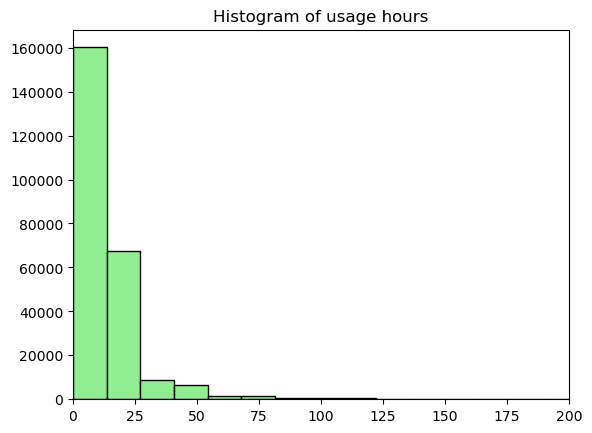

In [28]:
plt.hist(swap_data['usage_hours'], bins=200, color='lightgreen', edgecolor='black')
plt.xlim(0, 200)
plt.title('Histogram of usage hours')
# plt.ylim(0,100000)
plt.savefig('visuals/histogram-of-usage-hours.png', bbox_inches='tight')
plt.show()

In [29]:
swap_data = swap_data[swap_data['usage_hours'] <= 60]
swap_data.describe()

,swap_in_date,swap_in_SOC,swap_out_date,swap_out_SOC,usage_time,usage_hours
count,243460,243460.000000,243460,243460.000000,243460,243460.000000
mean,2024-07-18 13:14:24.542405888,28.219001,2024-07-18 01:50:02.103594496,98.842266,0 days 11:24:22.438811303,11.406233
min,2024-01-01 01:28:17,0.000000,2024-01-01 00:28:12,0.000000,0 days 00:00:01,0.000278
25%,2024-05-03 19:40:52.249999872,15.000000,2024-05-03 12:43:51.750000128,100.000000,0 days 03:33:50,3.563889
50%,2024-08-04 18:35:24,26.000000,2024-08-04 09:12:09,100.000000,0 days 07:48:12,7.803333
75%,2024-10-07 06:12:26.249999872,39.000000,2024-10-06 13:41:49.249999872,100.000000,0 days 16:32:16,16.537778
max,2024-12-11 10:49:57,23258.000000,2024-12-11 09:26:09,100.000000,2 days 11:59:45,59.995833
std,NaN,50.785420,NaN,6.166769,0 days 10:18:21.741113384,10.306039


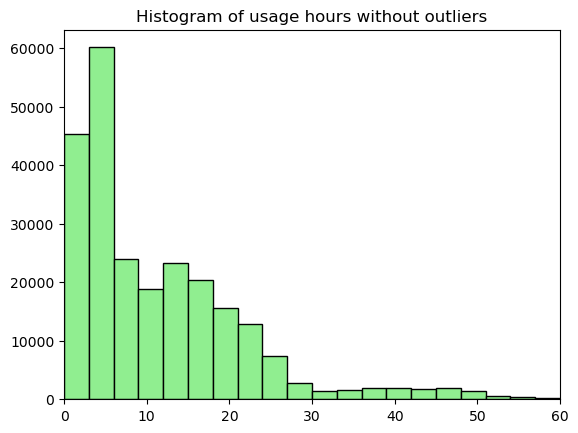

In [30]:
plt.hist(swap_data['usage_hours'], bins=20, color='lightgreen', edgecolor='black')
plt.xlim(0, 60)
plt.title('Histogram of usage hours without outliers')
# plt.ylim(0,100000)
plt.savefig('visuals/histogram-of-usage-hours-without-outliers.png', bbox_inches='tight')
plt.show()

- Try identifying batteries with fast decline in usage hours

In [31]:
# Start be confirm all data is of year 2024
print(sum(swap_data['swap_in_date'].apply(lambda x: x.year) != 2024))
print(sum(swap_data['swap_out_date'].dropna().apply(lambda x: x.year) != 2024))

0
0


In [32]:
# Group data by month and and batteriy id
monthly_swap_data = swap_data.copy()
monthly_swap_data['_month'] = monthly_swap_data['swap_in_date'].apply(lambda x: x.month) # getting the month from the dates
monthly_swap_data.drop(columns=['swap_in_date', 'swap_out_date'], inplace=True) # drop these as they are nolonger needed
monthly_swap_data = monthly_swap_data.groupby(['battery_id', '_month']).mean().reset_index() # grouping by battery id and month
monthly_swap_data.head()

,battery_id,_month,swap_in_SOC,swap_out_SOC,usage_time,usage_hours
0,BGR1001,1,31.181818,99.030303,0 days 07:04:41.818181818,7.078283
1,BGR1001,4,30.250000,100.000000,0 days 07:44:41.250000,7.744792
2,BGR1001,5,29.851852,99.555556,0 days 08:57:56.444444444,8.965679
3,BGR1001,6,28.833333,99.944444,0 days 12:48:40.500000,12.811250
4,BGR1001,7,25.392857,99.535714,0 days 11:07:36.178571428,11.126716


In [33]:
# change data to long format 
reg_data = monthly_swap_data.pivot(columns='_month', index='battery_id', values ='usage_hours')
reg_data.head()

_month,1,2,3,4,5,6,7,8,9,10,11,12
battery_id,,,,,,,,,,,,
BGR1001,7.078283,NaN,NaN,7.744792,8.965679,12.811250,11.126716,9.417554,7.552389,8.699701,10.778351,6.403135
BGR1002,8.179937,10.357458,15.833131,16.090778,9.505585,10.556447,11.783958,NaN,NaN,NaN,NaN,NaN
BGR1003,8.667133,9.468858,10.616956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BGR1004,7.378989,8.697622,13.763952,13.306100,8.830565,10.524124,10.363814,11.981510,13.103038,9.897661,8.394470,6.924667
BGR1005,10.066049,14.972847,9.354653,13.833382,9.492804,8.058009,11.355957,19.063510,6.264938,8.976042,5.431667,9.113056


In [34]:
reg_data['trend'] = reg_data.apply(get_trend, axis=1)

In [35]:
batteries_with_fast_decline = reg_data[reg_data['trend'] < -2].reset_index()
batteries_with_fast_decline.shape

(75, 14)

In [36]:
batteries_with_fast_decline.to_csv('batteries_with_fast_decline.csv', index=False)

#### Notes
- There are 75 batteries whose usage hours are decreasing drastically (reducing by 2 every month)
- Check which cluster they are from - from the other dataset.
- Also, they need to be checked by techinian

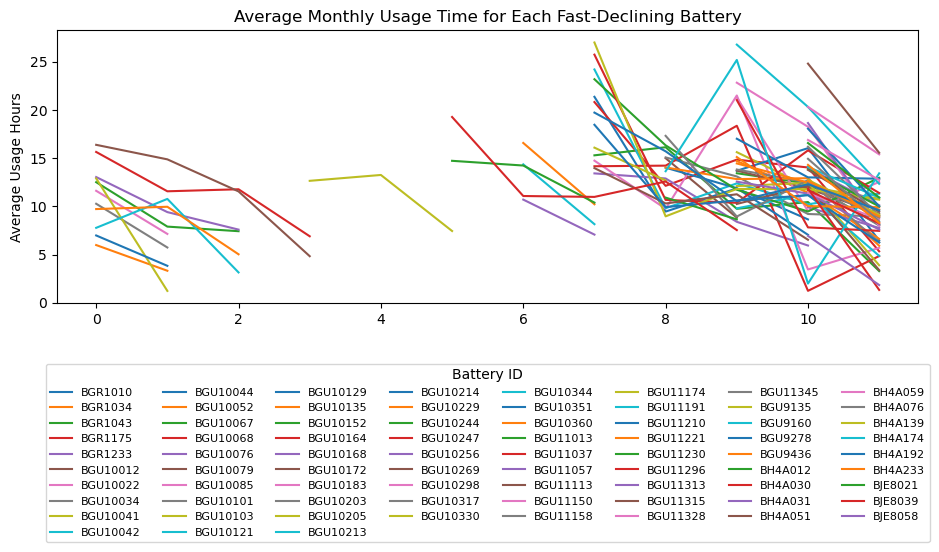

In [37]:
plt.figure(figsize=(10, 6))

# Loop through each battery (row)
for index, row in batteries_with_fast_decline.iterrows():
    plt.plot(range(12), row.values[1:13], label=row['battery_id'])

plt.title('Average Monthly Usage Time for Each Fast-Declining Battery')
plt.xlabel('')
plt.ylabel('Average Usage Hours')
plt.legend(title='Battery ID', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=8, fontsize=8)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('visuals/avg-monthly-usage-hours-for-fast-declining-batteries', bbox_inches='tight')
plt.show()


In [38]:
# find these batteries in the batteries dataset
batteries_with_fast_decline[[i in km_data.index for i in batteries_with_fast_decline['battery_id']]]

_month,battery_id,1,2,3,4,5,6,7,8,9,10,11,12,trend
59,BGU9160,NaN,NaN,NaN,NaN,NaN,NaN,14.351319,8.147076,NaN,NaN,NaN,NaN,-6.204243


In [39]:
km_data.loc['BGU9160']['cluster'] # in case where we have all batteries data, the index here will be a list

1.0

- The battery belongs to cluster one. We shall investigate what's wrong with batteries in this group.

- Now we check which batteries have (generally) a low average usage hours over the period of analysis

In [40]:
# Group by battery_id and check the summary statistics
grouped_by_battery = swap_data.groupby('battery_id').mean()['usage_hours'].reset_index()
summary = grouped_by_battery.describe()
summary

,usage_hours
count,1615.000000
mean,11.443668
std,1.726067
min,1.013333
25%,10.647846
50%,11.339096
75%,12.095749
max,41.842917


In [41]:
# Using the z-score method:
mean = summary.loc['mean', 'usage_hours']
std = summary.loc['std', 'usage_hours']

In [42]:
# Findind the z-score of ech battery
grouped_by_battery['z_score'] = (grouped_by_battery['usage_hours'] - mean) / std
grouped_by_battery['low_usage?'] = grouped_by_battery['z_score'].apply(lambda x: x <= -2)
grouped_by_battery.head()

,battery_id,usage_hours,z_score,low_usage?
0,BGR1001,9.262078,-1.263908,False
1,BGR1002,10.887921,-0.321973,False
2,BGR1003,9.501795,-1.125027,False
3,BGR1004,10.280474,-0.673898,False
4,BGR1005,10.878298,-0.327548,False


In [43]:
batteries_with_low_usage_generally = grouped_by_battery[grouped_by_battery['low_usage?']]
batteries_with_low_usage_generally.to_csv('batteries_with_low_usage_generally.csv', index=False)

In [44]:
batteries_with_low_usage_generally.shape

(22, 4)

#### Notes
- Identified 22 batteries with low average usage time over the entire period

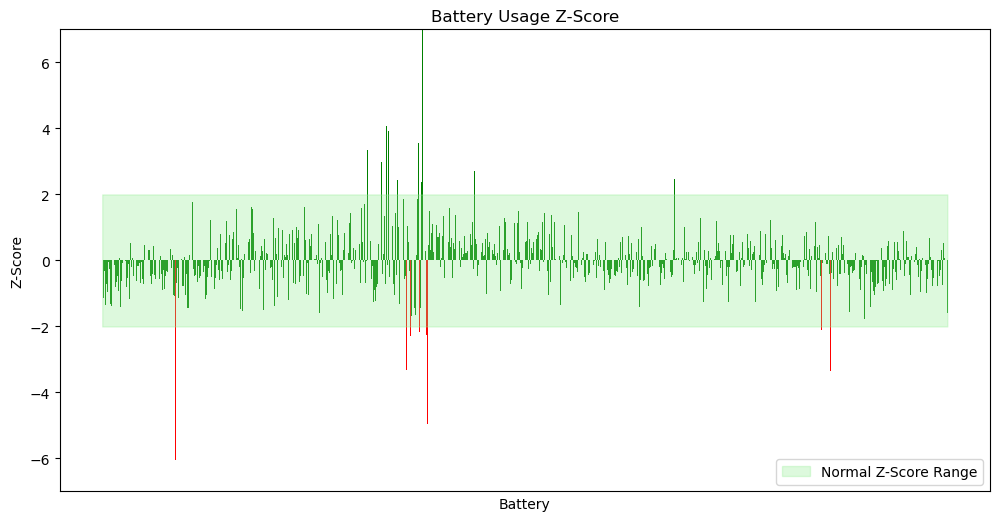

In [45]:
# Plotting the z-scores of all batteries
plt.figure(figsize=(12, 6))
plt.bar(grouped_by_battery['battery_id'], grouped_by_battery['z_score'], color='green') # plot full data
plt.bar(batteries_with_low_usage_generally['battery_id'], batteries_with_low_usage_generally['z_score'], color='red') # mark those below the threshold in red
plt.fill_between(grouped_by_battery['battery_id'], -2, 2, color='lightgreen', alpha=0.3, label='Normal Z-Score Range') # plot the normal z-score range
plt.title('Battery Usage Z-Score') # chart title
plt.xlabel('Battery') # x-axis title
plt.xticks([]) # remove x labels to make the visualization clean
plt.ylabel('Z-Score') # y-axis title
plt.ylim(-7, 7) # y-axis range
plt.legend(loc='lower right') # position legend
plt.savefig('visuals/battery_z_score_plot.png', bbox_inches='tight')  # Save image in current directory
plt.show()

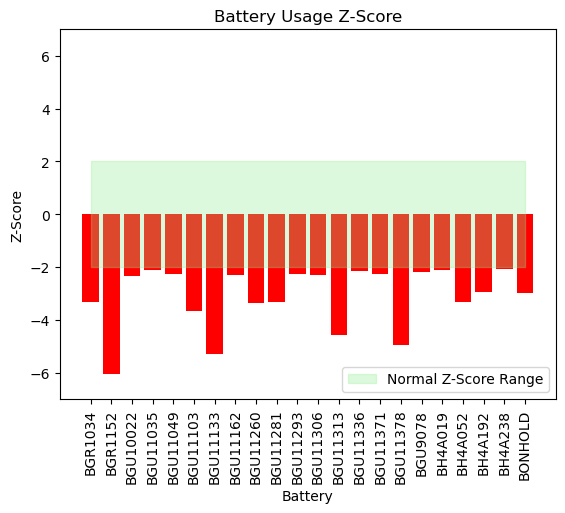

In [46]:
# Plotting z-scores of low usage batteries
plt.bar(batteries_with_low_usage_generally['battery_id'], batteries_with_low_usage_generally['z_score'], color='red')
plt.fill_between(batteries_with_low_usage_generally['battery_id'], -2, 2, color='lightgreen', alpha=0.3, label='Normal Z-Score Range')
plt.title('Battery Usage Z-Score')
plt.xlabel('Battery')
plt.xticks(rotation=90)
plt.ylabel('Z-Score')
plt.ylim(-7, 7)
plt.legend(loc='lower right')
plt.savefig('visuals/low-usage-batteries-z-scores.png', bbox_inches='tight')
plt.show()

In [47]:
# check which cluster they are from
batteries_with_low_usage_generally[[i in km_data.index for i in batteries_with_low_usage_generally['battery_id']]]

,battery_id,usage_hours,z_score,low_usage?
943,BGU9078,7.662476,-2.19064,True


In [48]:
km_data.loc['BGU9078']['cluster'] # in case where we have all batteries data, the index here will be a list

1.0

- This one is also from cluster 1

In [49]:
km_data[km_data['cluster'] == 1].describe()

,Battery_control,Battery_status,Cell_series_numbe_23_series,Location_type,Total_charged_capacity,alarmDesc,alarmFlag,times_100_of_battery_capacity,Maximum_Charge_Current,Total_charge_protect_voltage,cluster
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.0,43.000000,43.000000,43.000000,43.0
mean,2.197674,0.453488,32.558140,3.697674,1536.884147,38.813953,0.0,2074.599731,48.787510,8267.341158,1.0
std,1.118777,0.585682,18.466575,1.372084,414.189373,253.662788,0.0,480.297341,7.390753,51.178954,0.0
min,0.000000,0.000000,12.000000,1.000000,821.271366,0.000000,0.0,600.382989,39.996550,8059.211582,1.0
25%,2.000000,0.000000,24.000000,3.000000,1185.809043,0.000000,0.0,1730.360690,45.628757,8270.965008,1.0
50%,2.000000,0.000000,24.000000,3.000000,1460.026782,0.000000,0.0,2227.840202,47.974736,8273.379464,1.0
75%,2.000000,1.000000,24.000000,5.000000,1889.891106,0.000000,0.0,2459.710970,50.615709,8275.715455,1.0
max,4.000000,2.000000,100.000000,5.000000,2309.652625,1663.500000,0.0,2723.220742,89.818892,8382.691851,1.0


In [50]:
km_data.describe()

,Battery_control,Battery_status,Cell_series_numbe_23_series,Location_type,Total_charged_capacity,alarmDesc,alarmFlag,times_100_of_battery_capacity,Maximum_Charge_Current,Total_charge_protect_voltage,cluster
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,2.088083,0.352332,32.974093,3.668394,3102.514998,60.025907,51.093264,1925.466636,77.823875,8227.912256,1.404145
std,0.803646,1.772976,17.529866,1.918627,996.071571,388.381168,370.705622,523.306539,203.689776,403.485371,1.331659
min,0.000000,0.000000,0.000000,1.000000,821.271366,0.000000,0.000000,97.962959,39.996550,3360.270124,0.000000
25%,2.000000,0.000000,24.000000,3.000000,2518.684160,0.000000,0.000000,1547.724587,53.168958,8271.481224,0.000000
50%,2.000000,0.000000,24.000000,3.000000,3303.541412,0.000000,0.000000,2027.322313,61.065454,8273.533589,1.000000
75%,2.000000,0.000000,24.000000,5.000000,3925.753806,0.000000,0.000000,2371.769294,65.063335,8275.758989,2.000000
max,4.000000,24.000000,100.000000,24.000000,4633.270189,3330.000000,3330.000000,2835.799443,2828.155063,8382.691851,4.000000


### Observations:
- They have low total charged capacity
- low alarm desc, alarm flag, 
- maximum charge current

<div style="background-color: green; padding: 5px;">
    
# Part 6 - Predictive Analysis

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')
# from sklean

## 1. Point estimate of expected usage hours
- Combines battery features info and swap info, then predicts expected usage hours given battery info

In [52]:
# Define X (battery info) and y (usage time/hours) variables

In [53]:
X_raw = pd.read_csv('files/grouped-data-bymonth.csv')
X_raw = X_raw.groupby('devId').mean().drop(columns='_month')
X_raw.head()

,BMS_PCB_board_surface_temperature,Battery_control,Battery_status,Cell_series_numbe_23_series,Internal_temperature_of_battery,Location_type,Mileage,Number_of_cycles,SOC,Speed_information,...,Total_current,Total_discharged_capacity,Total_voltage,alarmDesc,alarmFlag,times_100_of_battery_capacity,Maximum_Charge_Current,Nominal_Capacity,Total_charge_protect_voltage,total_cell_voltage
devId,,,,,,,,,,,,,,,,,,,,,
BGU9001,30.266850,2.0,0.0,24.0,21.332766,3.0,4682.978610,2210.406466,74.488295,3.233135,...,333.684914,2801.778634,7490.638025,0.0,0.0,2147.510001,58.186780,47.213393,8271.066132,2.204762e+09
BGU9002,30.210839,2.0,1.0,24.0,21.626418,3.0,4198.982736,2241.892249,47.299202,3.707711,...,340.223984,2656.158040,7424.586806,0.0,0.0,1406.295115,56.427245,45.529093,8272.617541,2.347503e+09
BGU9003,29.618494,2.0,0.0,24.0,21.585863,3.0,6860.133406,2200.294906,31.128143,4.298579,...,330.751408,3465.216748,7335.046310,5.5,0.0,903.056322,61.525019,50.602327,8273.533589,2.021443e+09
BGU9004,29.186359,2.0,0.0,24.0,21.927345,3.0,7867.439743,2238.606864,68.865686,3.949439,...,329.027849,4065.583846,7481.104489,0.0,0.0,1967.292336,68.534701,57.618195,8271.747821,2.595210e+09
BGU9005,26.494488,4.0,2.0,24.0,24.315584,5.0,5324.663541,67.196165,23.497657,1.920087,...,-5.530884,1954.067847,7720.015355,0.0,0.0,575.777546,40.000000,28.997753,8324.603132,4.454915e+03


In [54]:
y_raw = grouped_by_battery[['battery_id', 'usage_hours']]
y_raw

,battery_id,usage_hours
0,BGR1001,9.262078
1,BGR1002,10.887921
2,BGR1003,9.501795
3,BGR1004,10.280474
4,BGR1005,10.878298
...,...,...
1610,BJE8098,12.107044
1611,BJE8099,11.827829
1612,BJE8100,11.085013
1613,BONHOLD,6.275557


- We need to ensure that the battery ids align in X and y datasets

In [55]:
# picks battery ids that are available in X
y = y_raw[[i in X_raw.index for i in y_raw['battery_id']]]
y.set_index('battery_id', inplace=True)

In [56]:
# picks battery ids that are in y
X = X_raw[[i in y.index for i in X_raw.index]]

In [57]:
# checking the distribution of X
X_summary = X.describe()
X_summary

,BMS_PCB_board_surface_temperature,Battery_control,Battery_status,Cell_series_numbe_23_series,Internal_temperature_of_battery,Location_type,Mileage,Number_of_cycles,SOC,Speed_information,...,Total_current,Total_discharged_capacity,Total_voltage,alarmDesc,alarmFlag,times_100_of_battery_capacity,Maximum_Charge_Current,Nominal_Capacity,Total_charge_protect_voltage,total_cell_voltage
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,...,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,1.920000e+02
mean,31.058890,2.078125,0.348958,33.083333,23.324548,3.661458,5512.572912,2337.036775,66.084266,3.792383,...,374.617590,3121.750292,7431.441008,60.338542,51.359375,1932.368114,78.015683,67.240288,8227.679376,2.494517e+09
std,2.886068,0.793719,1.776991,17.509708,3.082335,1.921216,2422.923150,745.217511,17.618927,2.306133,...,275.982817,983.017639,396.865763,389.372196,371.656306,515.793280,204.204823,206.092269,404.527232,2.297534e+09
min,25.390042,0.000000,0.000000,0.000000,9.287733,1.000000,336.037272,35.622052,3.280796,0.000000,...,-8.552502,1000.622971,3490.219321,0.000000,0.000000,97.962959,39.996550,28.997753,3360.270124,2.549989e+03
25%,28.998832,2.000000,0.000000,24.000000,21.340089,3.000000,4305.448800,2182.813329,52.761463,2.749045,...,312.741262,2575.839474,7438.355337,0.000000,0.000000,1557.299283,53.902031,42.298784,8271.445035,1.991567e+09
50%,30.651643,2.000000,0.000000,24.000000,22.989662,3.000000,6009.872193,2237.017657,70.565321,3.507272,...,329.127130,3335.518843,7491.076599,0.000000,0.000000,2034.769097,61.103836,50.115825,8273.621436,2.205111e+09
75%,32.674338,2.000000,0.000000,24.000000,25.425249,5.000000,7488.214912,2295.692494,81.224359,4.001565,...,341.823626,3927.037208,7557.183128,0.000000,0.000000,2371.912424,65.079179,54.202450,8275.760709,2.392255e+09
max,38.129624,4.000000,24.000000,100.000000,30.486825,24.000000,9435.950764,7679.099483,95.698413,15.307229,...,2970.322917,4646.624113,7993.566206,3330.000000,3330.000000,2835.799443,2828.155063,2843.537975,8382.691851,2.389061e+10


In [58]:
# Handling outliers before model fitting
X_summary.loc['lower_limit'] = X_summary.loc['mean'] - 2 * X_summary.loc['std'] # define lower limit
X_summary.loc['upper_limit'] = X_summary.loc['mean'] + 2 * X_summary.loc['std'] # define upper limit
X_summary

,BMS_PCB_board_surface_temperature,Battery_control,Battery_status,Cell_series_numbe_23_series,Internal_temperature_of_battery,Location_type,Mileage,Number_of_cycles,SOC,Speed_information,...,Total_current,Total_discharged_capacity,Total_voltage,alarmDesc,alarmFlag,times_100_of_battery_capacity,Maximum_Charge_Current,Nominal_Capacity,Total_charge_protect_voltage,total_cell_voltage
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,...,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,1.920000e+02
mean,31.058890,2.078125,0.348958,33.083333,23.324548,3.661458,5512.572912,2337.036775,66.084266,3.792383,...,374.617590,3121.750292,7431.441008,60.338542,51.359375,1932.368114,78.015683,67.240288,8227.679376,2.494517e+09
std,2.886068,0.793719,1.776991,17.509708,3.082335,1.921216,2422.923150,745.217511,17.618927,2.306133,...,275.982817,983.017639,396.865763,389.372196,371.656306,515.793280,204.204823,206.092269,404.527232,2.297534e+09
min,25.390042,0.000000,0.000000,0.000000,9.287733,1.000000,336.037272,35.622052,3.280796,0.000000,...,-8.552502,1000.622971,3490.219321,0.000000,0.000000,97.962959,39.996550,28.997753,3360.270124,2.549989e+03
25%,28.998832,2.000000,0.000000,24.000000,21.340089,3.000000,4305.448800,2182.813329,52.761463,2.749045,...,312.741262,2575.839474,7438.355337,0.000000,0.000000,1557.299283,53.902031,42.298784,8271.445035,1.991567e+09
50%,30.651643,2.000000,0.000000,24.000000,22.989662,3.000000,6009.872193,2237.017657,70.565321,3.507272,...,329.127130,3335.518843,7491.076599,0.000000,0.000000,2034.769097,61.103836,50.115825,8273.621436,2.205111e+09
75%,32.674338,2.000000,0.000000,24.000000,25.425249,5.000000,7488.214912,2295.692494,81.224359,4.001565,...,341.823626,3927.037208,7557.183128,0.000000,0.000000,2371.912424,65.079179,54.202450,8275.760709,2.392255e+09
max,38.129624,4.000000,24.000000,100.000000,30.486825,24.000000,9435.950764,7679.099483,95.698413,15.307229,...,2970.322917,4646.624113,7993.566206,3330.000000,3330.000000,2835.799443,2828.155063,2843.537975,8382.691851,2.389061e+10
lower_limit,25.286754,0.490687,-3.205023,-1.936083,17.159878,-0.180974,666.726612,846.601752,30.846411,-0.819882,...,-177.348043,1155.715013,6637.709481,-718.405850,-691.953236,900.781554,-330.393963,-344.944251,7418.624913,-2.100551e+09
upper_limit,36.831026,3.665563,3.902939,68.102750,29.489217,7.503891,10358.419213,3827.471797,101.322120,8.404649,...,926.583223,5087.785571,8225.172534,839.082933,794.671986,2963.954674,486.425330,479.424827,9036.733840,7.089586e+09


In [59]:
# cap values at lower_limit and upper_limit
for index in X.index:
    X.loc[index] = np.minimum(X.loc[index], X_summary.loc['upper_limit'])
    X.loc[index] = np.maximum(X.loc[index], X_summary.loc['lower_limit'])

In [60]:
# checking the result...
(X < X_summary.loc['lower_limit']).sum()

BMS_PCB_board_surface_temperature             0
Battery_control                               0
Battery_status                                0
Cell_series_numbe_23_series                   0
Internal_temperature_of_battery               0
Location_type                                 0
Mileage                                       0
Number_of_cycles                              0
SOC                                           0
Speed_information                             0
Surface_temperature_in_the_middle_of_cells    0
Total_charged_capacity                        0
Total_current                                 0
Total_discharged_capacity                     0
Total_voltage                                 0
alarmDesc                                     0
alarmFlag                                     0
times_100_of_battery_capacity                 0
Maximum_Charge_Current                        0
Nominal_Capacity                              0
Total_charge_protect_voltage            

In [61]:
(X < X_summary.loc['lower_limit']).sum()

BMS_PCB_board_surface_temperature             0
Battery_control                               0
Battery_status                                0
Cell_series_numbe_23_series                   0
Internal_temperature_of_battery               0
Location_type                                 0
Mileage                                       0
Number_of_cycles                              0
SOC                                           0
Speed_information                             0
Surface_temperature_in_the_middle_of_cells    0
Total_charged_capacity                        0
Total_current                                 0
Total_discharged_capacity                     0
Total_voltage                                 0
alarmDesc                                     0
alarmFlag                                     0
times_100_of_battery_capacity                 0
Maximum_Charge_Current                        0
Nominal_Capacity                              0
Total_charge_protect_voltage            

In [62]:
# scaling the features
X = MinMaxScaler().fit_transform(X)

- Now, we fit the regression model

In [63]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [64]:
# linear regression model
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print(f'MSE: {mse(y_test, y_pred_lr) : 0.3}')

MSE:  1.49


In [65]:
# decision tree regression
dt = DecisionTreeRegressor(criterion='absolute_error', min_samples_split=10, random_state=0)
dt_model = dt.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(f'MSE: {mse(y_test, y_pred_dt) : 0.3}')

MSE:  1.35


In [66]:
# gradient boost regressor
gb = GradientBoostingRegressor(loss='absolute_error', random_state=0)
gb_model = gb.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
print(f'MSE: {mse(y_test, y_pred_gb) : 0.3}')

MSE:  1.5


- Decision tree performs best so far. Might need some improvement

## 2. Time series prediction

- Predicts a series of usage hours given historical usage hours. Can be used to predict battery life.

In [67]:
pred = {} # initialize dictionary to store predictions for each battery
for index in reg_data.index: # iterate through each batteries history
    arima_fit = ARIMA(reg_data.loc[index][:12], order=(1, 1, 0)).fit() # fit arima mode
    pred[index] = arima_fit.forecast(10) # use the fitted arima model to predict and store predicted values.

In [68]:
# predicted average usage hours for the next 10 months
pred = pd.DataFrame(pred).T
pred.head()

,1970-01-01 00:00:00.000000013,1970-01-01 00:00:00.000000014,1970-01-01 00:00:00.000000015,1970-01-01 00:00:00.000000016,1970-01-01 00:00:00.000000017,1970-01-01 00:00:00.000000018,1970-01-01 00:00:00.000000019,1970-01-01 00:00:00.000000020,1970-01-01 00:00:00.000000021,1970-01-01 00:00:00.000000022
BGR1001,7.284263,7.106812,7.142549,7.135352,7.136801,7.136510,7.136568,7.136556,7.136559,7.136558
BGR1002,11.873956,11.873956,11.873956,11.873956,11.873956,11.873956,11.873956,11.873956,11.873956,11.873956
BGR1003,18.864025,19.437333,19.975567,20.480871,20.955262,21.400630,21.818750,22.211290,22.579815,22.925794
BGR1004,6.851738,6.848119,6.847940,6.847931,6.847930,6.847930,6.847930,6.847930,6.847930,6.847930
BGR1005,7.046541,8.206560,7.555394,7.920920,7.715736,7.830914,7.766260,7.802553,7.782180,7.793616


In [69]:
# Testing the time series model
pred_test = {} # initialize dictionary to store predictions for each battery
for index in reg_data.index: # iterate through each batteries history
    arima_fit = ARIMA(reg_data.loc[index][:11], order=(1, 0, 0)).fit() # fit arima mode
    pred_test[index] = arima_fit.forecast() # use the fitted arima model to predict and store predicted values.

In [70]:
pred_test = pd.DataFrame(pred_test).T
pred_test.columns = ['pred']

true_test = reg_data.loc[:,12].to_frame()
true_test.columns = ['true']

In [71]:
# Drop NaN
true_test = true_test[(true_test['true'].isna() == False) & (pred_test['pred'].isna() == False)]
pred_test = pred_test[(true_test['true'].isna() == False) & (pred_test['pred'].isna() == False)]
mae(true_test, pred_test)

4.34402016639165

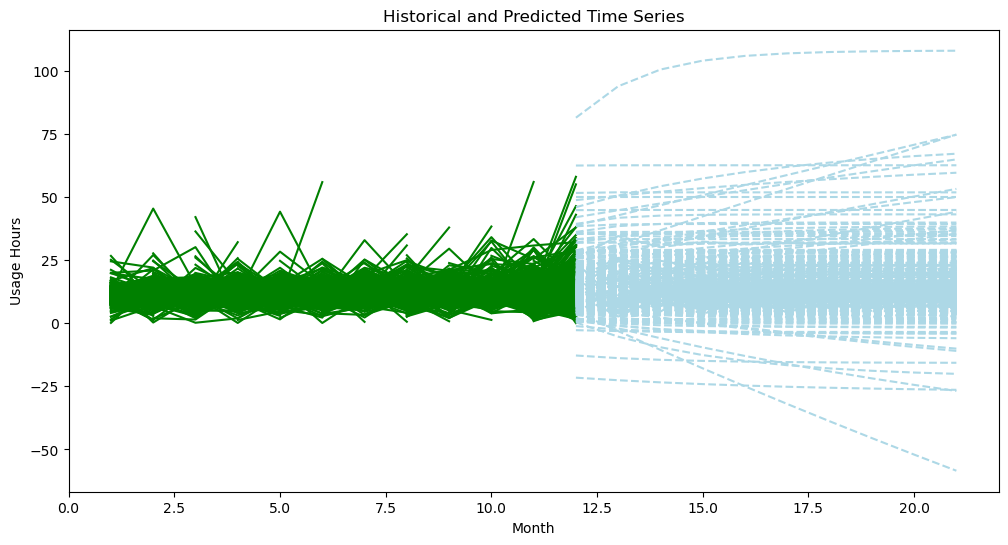

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(reg_data.columns[:12], reg_data.T.loc[:12], label='Historical Data', color='green')
plt.plot(range(12, 12 + pred.shape[1]), pred.T, label='Predicted Data', color='lightblue', linestyle='--')
plt.title('Historical and Predicted Time Series')
plt.xlabel('Month')
plt.ylabel('Usage Hours')
# plt.legend()
plt.show()

#### Notes
 - Improvement to be made: better to do this with daily data.